# Idle States Residency Analysis

In [2]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2018-05-31 17:49:28,756 INFO    : root         : Using LISA logging configuration:
2018-05-31 17:49:28,766 INFO    : root         :   /home/leoy/Work2/Develop/tools/lisa/logging.conf


In [3]:
%matplotlib inline

import os

# Support to access the remote target
from env import TestEnv

# Support to access cpuidle information from the target
from devlib import *

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace
from trace import ResidencyTime, ResidencyData

# DataFrame support
import pandas as pd
from pandas import DataFrame

# Trappy (plots) support
from trappy import ILinePlot
from trappy.stats.grammar import Parser

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

In [4]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"     : 'generic_linux',
    "board"        : 'hikey',
    
    # Folder where all the results will be collected
    "results_dir" : "taskset_test",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq',
        'cpuidle'
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_idle",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset', 'rt-app', 'sysbench'],
}

In [5]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            280000,
            432000,
            729000,
            960000,
            1200000
        ],
        'little': [
            280000,
            432000,
            729000,
            960000,
            1200000
        ]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 112
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 607
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 112
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 607
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

# Plot for idle state statistics comparison

In [5]:
def plotCPUIdleStateResidencyComparison(prev_ia, post_ia, cpus=None, pct=False):
    if not prev_ia._trace.hasEvents('cpu_idle'):
        prev_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if not post_ia._trace.hasEvents('cpu_idle'):
        post_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if cpus is None:
        # Generate plots only for available CPUs
        cpuidle_data = prev_ia._dfg_trace_event('cpu_idle')
        _cpus = range(cpuidle_data.cpu_id.max() + 1)
    else:
        _cpus = listify(cpus)
    
    # print _cpus
    
    xmax = 0.0 
    
    prev_residencies = []
    post_residencies = []
    
    for cpu in _cpus:
        r = prev_ia._dfg_cpu_idle_state_residency(cpu)
        prev_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for cpu in _cpus:
        r = post_ia._dfg_cpu_idle_state_residency(cpu)
        post_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    #print prev_residencies[0]
    #print post_residencies[0]
    
    n_plots = len(prev_residencies) + len(post_residencies)
    gs = gridspec.GridSpec(n_plots, 1)
    fig = plt.figure()

    for i, data in enumerate(prev_residencies):
        
        idx = i * 2
        
        prev_r = prev_residencies[i].residency
        post_r = post_residencies[i].residency
        
        #print prev_r
        #print post_r
        
        if prev_r is None:
            plt.close(fig)
            return
        
        if post_r is None:
            plt.close(fig)
            return
        
        is_first = idx == 0
        is_last  = (idx + 2) == n_plots
            
        axes = fig.add_subplot(gs[idx])

        yrange = 0.4 * max(6, len(r)) * n_plots
        
        if pct:
            duration = prev_r.time.sum()
            r_pct = prev_r.apply(lambda x: x*100/duration)
            r_pct.columns = [data.label]
            r_pct.T.plot.barh(ax=axes, stacked=True, figsize=(16, yrange))

            axes.legend(loc='lower center', ncol=7)
            axes.set_xlim(0, 100)
        else:
            prev_r.plot.barh(ax=axes, color='b',
                        legend=False, figsize=(16, yrange))

            axes.set_xlim(0, 1.05*xmax)
            axes.set_ylabel('Idle State')
            axes.set_title(data.label + ": Before Optimization")

        axes.grid(True)
        axes.set_xticklabels([])

        if is_first:
            legend_y = axes.get_ylim()[1]
            axes.annotate('Idle State Residency Time Comparison', xy=(0, legend_y),
                              xytext=(-50, 45), textcoords='offset points',
                              fontsize=18)
            
        axes = fig.add_subplot(gs[idx+1])

        yrange = 0.4 * max(6, len(r)) * n_plots
        
        if pct:
            duration = post_r.time.sum()
            r_pct = post_r.apply(lambda x: x*100/duration)
            r_pct.columns = [data.label]
            r_pct.T.plot.barh(ax=axes, stacked=True, figsize=(16, yrange))

            axes.legend(loc='lower center', ncol=7)
            axes.set_xlim(0, 100)
        else:
            post_r.plot.barh(ax=axes, color='g',
                        legend=False, figsize=(16, yrange))

            axes.set_xlim(0, 1.05*xmax)
            axes.set_ylabel('Idle State')
            axes.set_title(data.label + ": After Optimization")

        axes.grid(True)
        if is_last:
            if pct:
                axes.set_xlabel('Residency [%]')
            else:
                axes.set_xlabel('Time [s]')
        else:
            axes.set_xticklabels([])

# Calculate idle state statistics difference

In [6]:
def dfCPUIdleStateResidencyComparison(prev_ia, post_ia):
    df = pd.DataFrame(columns=('index', 'state0', 'state1', 'state2'))

    if not prev_ia._trace.hasEvents('cpu_idle'):
        prev_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    if not post_ia._trace.hasEvents('cpu_idle'):
        post_ia._log.warning('Events [cpu_idle] not found, plot DISABLED!')
        return
    
    # Generate plots only for available CPUs
    cpuidle_data = prev_ia._dfg_trace_event('cpu_idle')
    _cpus = range(cpuidle_data.cpu_id.max() + 1)
    
    xmax = 0.0 
    
    prev_residencies = []
    post_residencies = []
    
    for cpu in _cpus:
        r = prev_ia._dfg_cpu_idle_state_residency(cpu)
        prev_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for cpu in _cpus:
        r = post_ia._dfg_cpu_idle_state_residency(cpu)
        post_residencies.append(ResidencyData('CPU{}'.format(cpu), r)) 

        max_time = r.max().values[0]
        if xmax < max_time:
            xmax = max_time
            
    for i, data in enumerate(prev_residencies):
        
        idx = i * 2
        
        prev_r = prev_residencies[i].residency
        post_r = post_residencies[i].residency
        diff_r = post_r - prev_r
        
        df = df.append({'index': data.label+"(orig)", 'state0': prev_r['time'][0],
                        'state1': prev_r['time'][1], 'state2': prev_r['time'][2]}, ignore_index=True)
        df = df.append({'index': data.label+"(opt)", 'state0': post_r['time'][0],
                        'state1': post_r['time'][1], 'state2': post_r['time'][2]}, ignore_index=True)
        df = df.append({'index': data.label+"(delta)", 'state0': diff_r['time'][0],
                        'state1': diff_r['time'][1], 'state2': diff_r['time'][2]}, ignore_index=True)            
    return df

# Idle state estimation statistics (Check if break residency)

In [182]:
def dfCPUIdleStateEstimationStatistics(ia, cpu, residency):
    idle_df = ia._dfg_trace_event('cpu_idle')
    cpu_idle = idle_df[idle_df.cpu_id == cpu]

    available_idles = sorted(idle_df.state.unique())
    available_idles = available_idles[1:]
    
    start_rec = False
    cpu_states = []
    for i in available_idles:
        cpu_states.append('CPU{}-c{}'.format(cpu, i))
    
    idle_time_df = pd.DataFrame({'over_est' : 0, 'under_est' : 0, 'good_est' : 0}, index=cpu_states)

    for date, row in cpu_idle.iterrows():

        if (start_rec == False and row['state'] < 0):
            continue

        start_rec = True
    
        if (row['state'] >= 0):
            enter_idle = date;
            state = row['state']
        else:
            exit_idle = date
            duration = (exit_idle - enter_idle) * 1000 * 1000
            idx = 'CPU{}-c{}'.format(row['cpu_id'], state)
            
            if (duration < residency[state]):
                idle_time_df.at[idx, 'over_est'] = idle_time_df.iloc[[state]]['over_est'] + 1
            elif (duration > residency[state+1]):
                idle_time_df.at[idx, 'under_est'] = idle_time_df.iloc[[state]]['under_est'] + 1
            else:
                idle_time_df.at[idx, 'good_est'] = idle_time_df.iloc[[state]]['good_est'] + 1
                
    return idle_time_df

In [187]:
def dfCPUIdleStateEstimationStatisticsHikey960(ia, hikey960_residency):
    
    idle_df = ia._dfg_trace_event('cpu_idle')
    available_idles = sorted(idle_df.state.unique())
    available_idles = available_idles[1:]
    
    cpu_states = []
    for i in available_idles:
        cpu_states.append('overall-c{}'.format(i))
    
    overall_df = pd.DataFrame({'over_est' : 0, 'under_est' : 0, 'good_est' : 0}, index=cpu_states)
    
    cpu_idle_est_df = dfCPUIdleStateEstimationStatistics(ia, 0, hikey960_residency)
    
    for i in available_idles:
        overall_df.at['overall-c{}'.format(i), 'under_est'] += cpu_idle_est_df.iloc[[i]]['under_est']
        overall_df.at['overall-c{}'.format(i), 'over_est'] += cpu_idle_est_df.iloc[[i]]['over_est']
        overall_df.at['overall-c{}'.format(i), 'good_est'] += cpu_idle_est_df.iloc[[i]]['good_est']
        
    df = dfCPUIdleStateEstimationStatistics(ia, 1, hikey960_residency)
    cpu_idle_est_df = cpu_idle_est_df.append(df, ignore_index=False)

    for i in available_idles:
        overall_df.at['overall-c{}'.format(i), 'under_est'] += df.iloc[[i]]['under_est']
        overall_df.at['overall-c{}'.format(i), 'over_est'] += df.iloc[[i]]['over_est']
        overall_df.at['overall-c{}'.format(i), 'good_est'] += df.iloc[[i]]['good_est']
        
    df = dfCPUIdleStateEstimationStatistics(ia, 2, hikey960_residency)
    cpu_idle_est_df = cpu_idle_est_df.append(df, ignore_index=False)

    for i in available_idles:
        overall_df.at['overall-c{}'.format(i), 'under_est'] += df.iloc[[i]]['under_est']
        overall_df.at['overall-c{}'.format(i), 'over_est'] += df.iloc[[i]]['over_est']
        overall_df.at['overall-c{}'.format(i), 'good_est'] += df.iloc[[i]]['good_est']
        
    df = dfCPUIdleStateEstimationStatistics(ia, 3, hikey960_residency)
    cpu_idle_est_df = cpu_idle_est_df.append(df, ignore_index=False)

    for i in available_idles:
        overall_df.at['overall-c{}'.format(i), 'under_est'] += df.iloc[[i]]['under_est']
        overall_df.at['overall-c{}'.format(i), 'over_est'] += df.iloc[[i]]['over_est']
        overall_df.at['overall-c{}'.format(i), 'good_est'] += df.iloc[[i]]['good_est']
        
    df = dfCPUIdleStateEstimationStatistics(ia, 4, hikey960_residency)
    cpu_idle_est_df = cpu_idle_est_df.append(df, ignore_index=False)

    for i in available_idles:
        overall_df.at['overall-c{}'.format(i), 'under_est'] += df.iloc[[i]]['under_est']
        overall_df.at['overall-c{}'.format(i), 'over_est'] += df.iloc[[i]]['over_est']
        overall_df.at['overall-c{}'.format(i), 'good_est'] += df.iloc[[i]]['good_est']
        
    df = dfCPUIdleStateEstimationStatistics(ia, 5, hikey960_residency)
    cpu_idle_est_df = cpu_idle_est_df.append(df, ignore_index=False)

    for i in available_idles:
        overall_df.at['overall-c{}'.format(i), 'under_est'] += df.iloc[[i]]['under_est']
        overall_df.at['overall-c{}'.format(i), 'over_est'] += df.iloc[[i]]['over_est']
        overall_df.at['overall-c{}'.format(i), 'good_est'] += df.iloc[[i]]['good_est']
        
    df = dfCPUIdleStateEstimationStatistics(ia, 6, hikey960_residency)
    cpu_idle_est_df = cpu_idle_est_df.append(df, ignore_index=False)

    for i in available_idles:
        overall_df.at['overall-c{}'.format(i), 'under_est'] += df.iloc[[i]]['under_est']
        overall_df.at['overall-c{}'.format(i), 'over_est'] += df.iloc[[i]]['over_est']
        overall_df.at['overall-c{}'.format(i), 'good_est'] += df.iloc[[i]]['good_est']
        
    df = dfCPUIdleStateEstimationStatistics(ia, 7, hikey960_residency)
    cpu_idle_est_df = cpu_idle_est_df.append(df, ignore_index=False)

    for i in available_idles:
        overall_df.at['overall-c{}'.format(i), 'under_est'] += df.iloc[[i]]['under_est']
        overall_df.at['overall-c{}'.format(i), 'over_est'] += df.iloc[[i]]['over_est']
        overall_df.at['overall-c{}'.format(i), 'good_est'] += df.iloc[[i]]['good_est']
        
    cpu_idle_est_df = cpu_idle_est_df.append(overall_df, ignore_index=False)
    return cpu_idle_est_df

# Idle state statistics and comparison for power nightmare case

## Read trace data before optimization

In [176]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/powernightmare/pre_opt'
trace_file = os.path.join(res_dir, "trace.dat")

In [177]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

2018-05-29 18:41:13,553 WARNING : Trace        : Failed to load tasks names from trace events


In [178]:
prev_ia = trace.analysis.idle

## Read trace data after optimization

In [159]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/powernightmare/post_opt'
trace_file = os.path.join(res_dir, "trace.dat")

In [160]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

In [161]:
post_ia = trace.analysis.idle

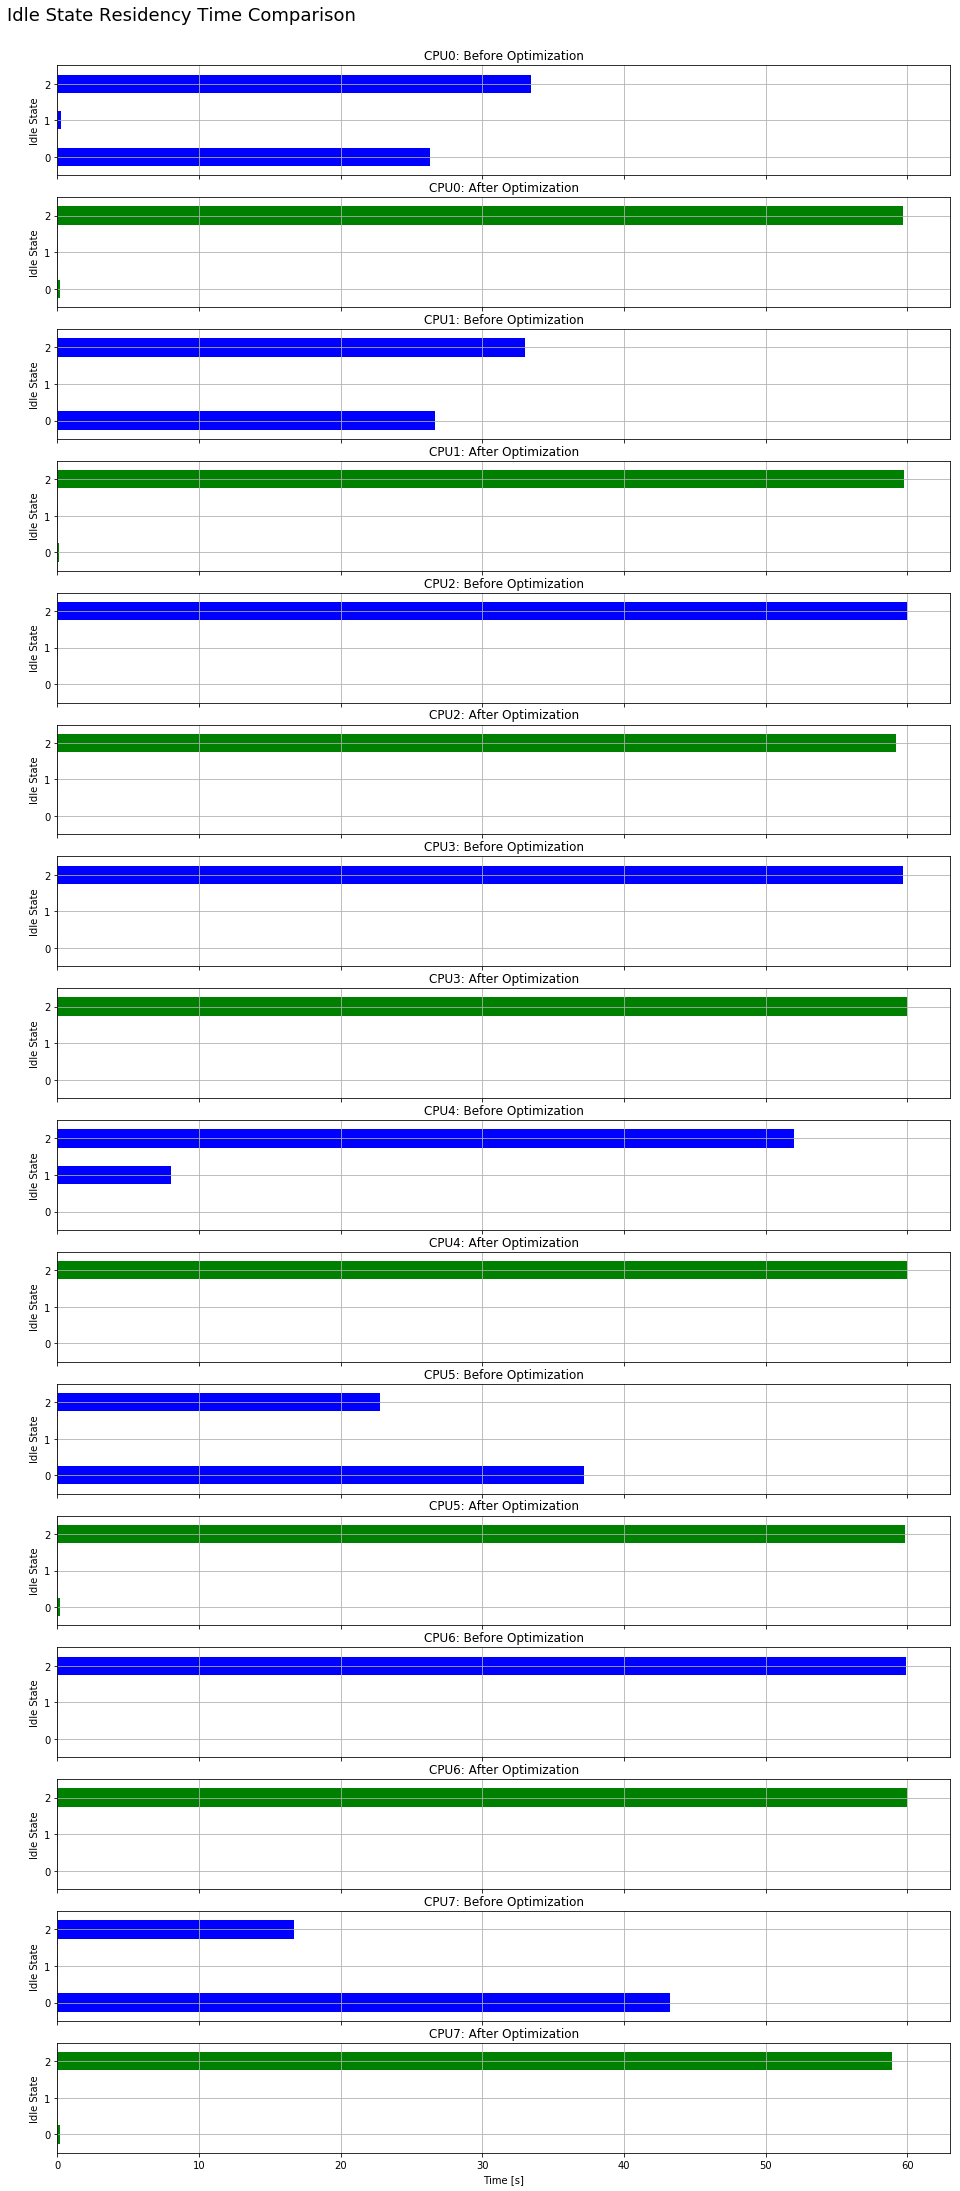

In [162]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [163]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),26.306209,0.257640,33.437085
1,CPU0(opt),0.176018,0.073155,59.723376
2,CPU0(delta),-26.130191,-0.184485,26.286291
3,CPU1(orig),26.672985,0.000000,33.031119
4,CPU1(opt),0.142790,0.058999,59.763389
5,CPU1(delta),-26.530195,0.058999,26.732270
6,CPU2(orig),0.006951,0.038756,59.945315
7,CPU2(opt),0.007959,0.042355,59.203853
8,CPU2(delta),0.001008,0.003599,-0.741462
9,CPU3(orig),0.079421,0.000171,59.685617


# Idle state statistics and comparison for rt-app video case (300s)

In [164]:
res_dir = '/home/leoy/Work2/Develop/wa-data/cpuidle_loop_rework_pre_opt_video/wk1-rt_app-1'
trace_file = os.path.join(res_dir, "trace.dat")

In [165]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

In [166]:
prev_ia = trace.analysis.idle

In [167]:
res_dir = '/home/leoy/Work2/Develop/wa-data/cpuidle_loop_rework_post_opt_video/wk1-rt_app-1'
trace_file = os.path.join(res_dir, "trace.dat")

In [168]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

In [169]:
post_ia = trace.analysis.idle

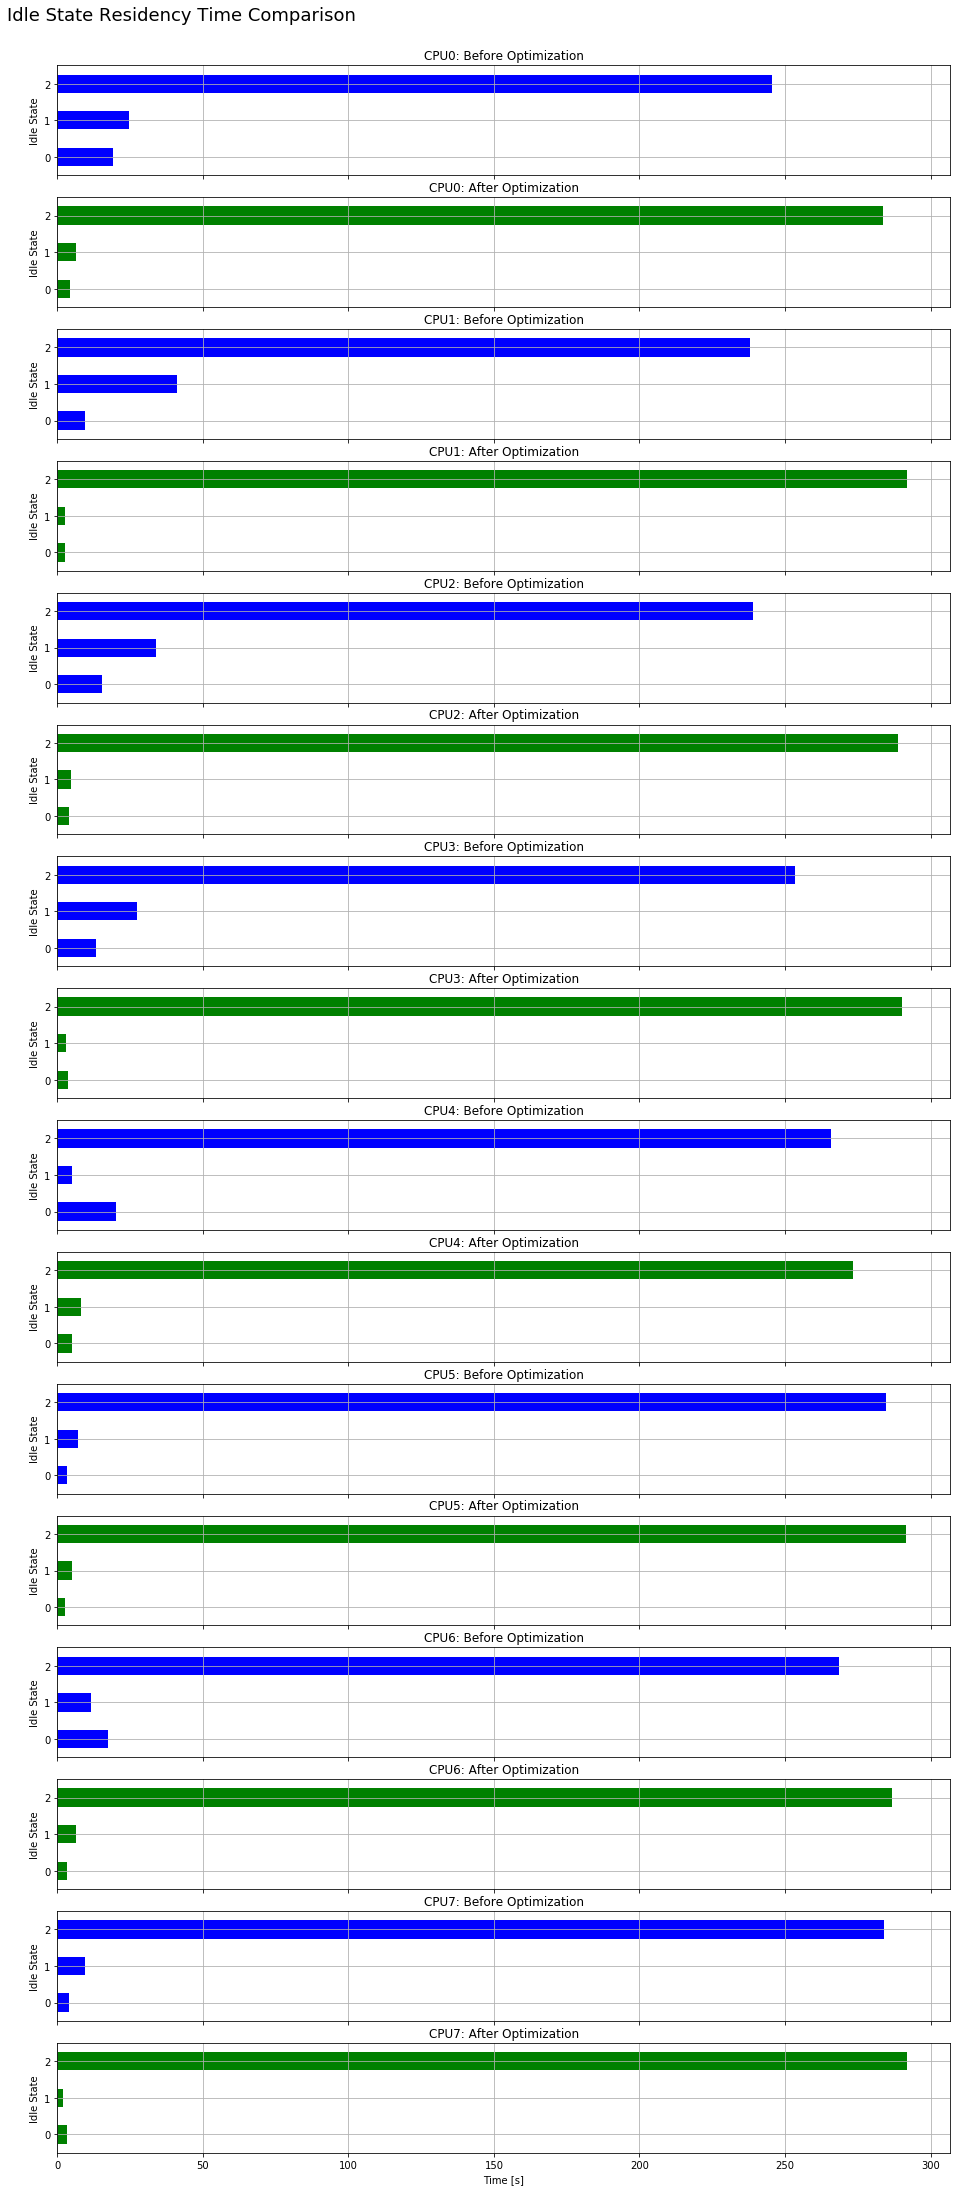

In [170]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [171]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),19.216752,24.535554,245.400615
1,CPU0(opt),4.355038,6.512938,283.748509
2,CPU0(delta),-14.861714,-18.022616,38.347894
3,CPU1(orig),9.684541,41.087236,237.964859
4,CPU1(opt),2.803859,2.593231,292.046794
5,CPU1(delta),-6.880682,-38.494005,54.081935
6,CPU2(orig),15.261803,33.862160,239.109379
7,CPU2(opt),4.101080,4.884871,288.679212
8,CPU2(delta),-11.160723,-28.977289,49.569833
9,CPU3(orig),13.379934,27.356345,253.385225


# Android 4.14: exoplayer audio case (state2 latency: 5000)

In [188]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent/prev_opt/audio/'
trace_file = os.path.join(res_dir, "trace.dat")

In [189]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

2018-05-29 18:45:36,661 WARNING : Trace        : Failed to load tasks names from trace events
2018-05-29 18:45:41,088 INFO    : Trace        : Platform clusters verified to be Frequency coherent


In [190]:
prev_ia = trace.analysis.idle

In [191]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent/post_opt/audio/'
trace_file = os.path.join(res_dir, "trace.dat")

In [192]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

2018-05-29 18:45:41,820 WARNING : Trace        : Failed to load tasks names from trace events
2018-05-29 18:45:46,187 INFO    : Trace        : Platform clusters verified to be Frequency coherent


In [193]:
post_ia = trace.analysis.idle

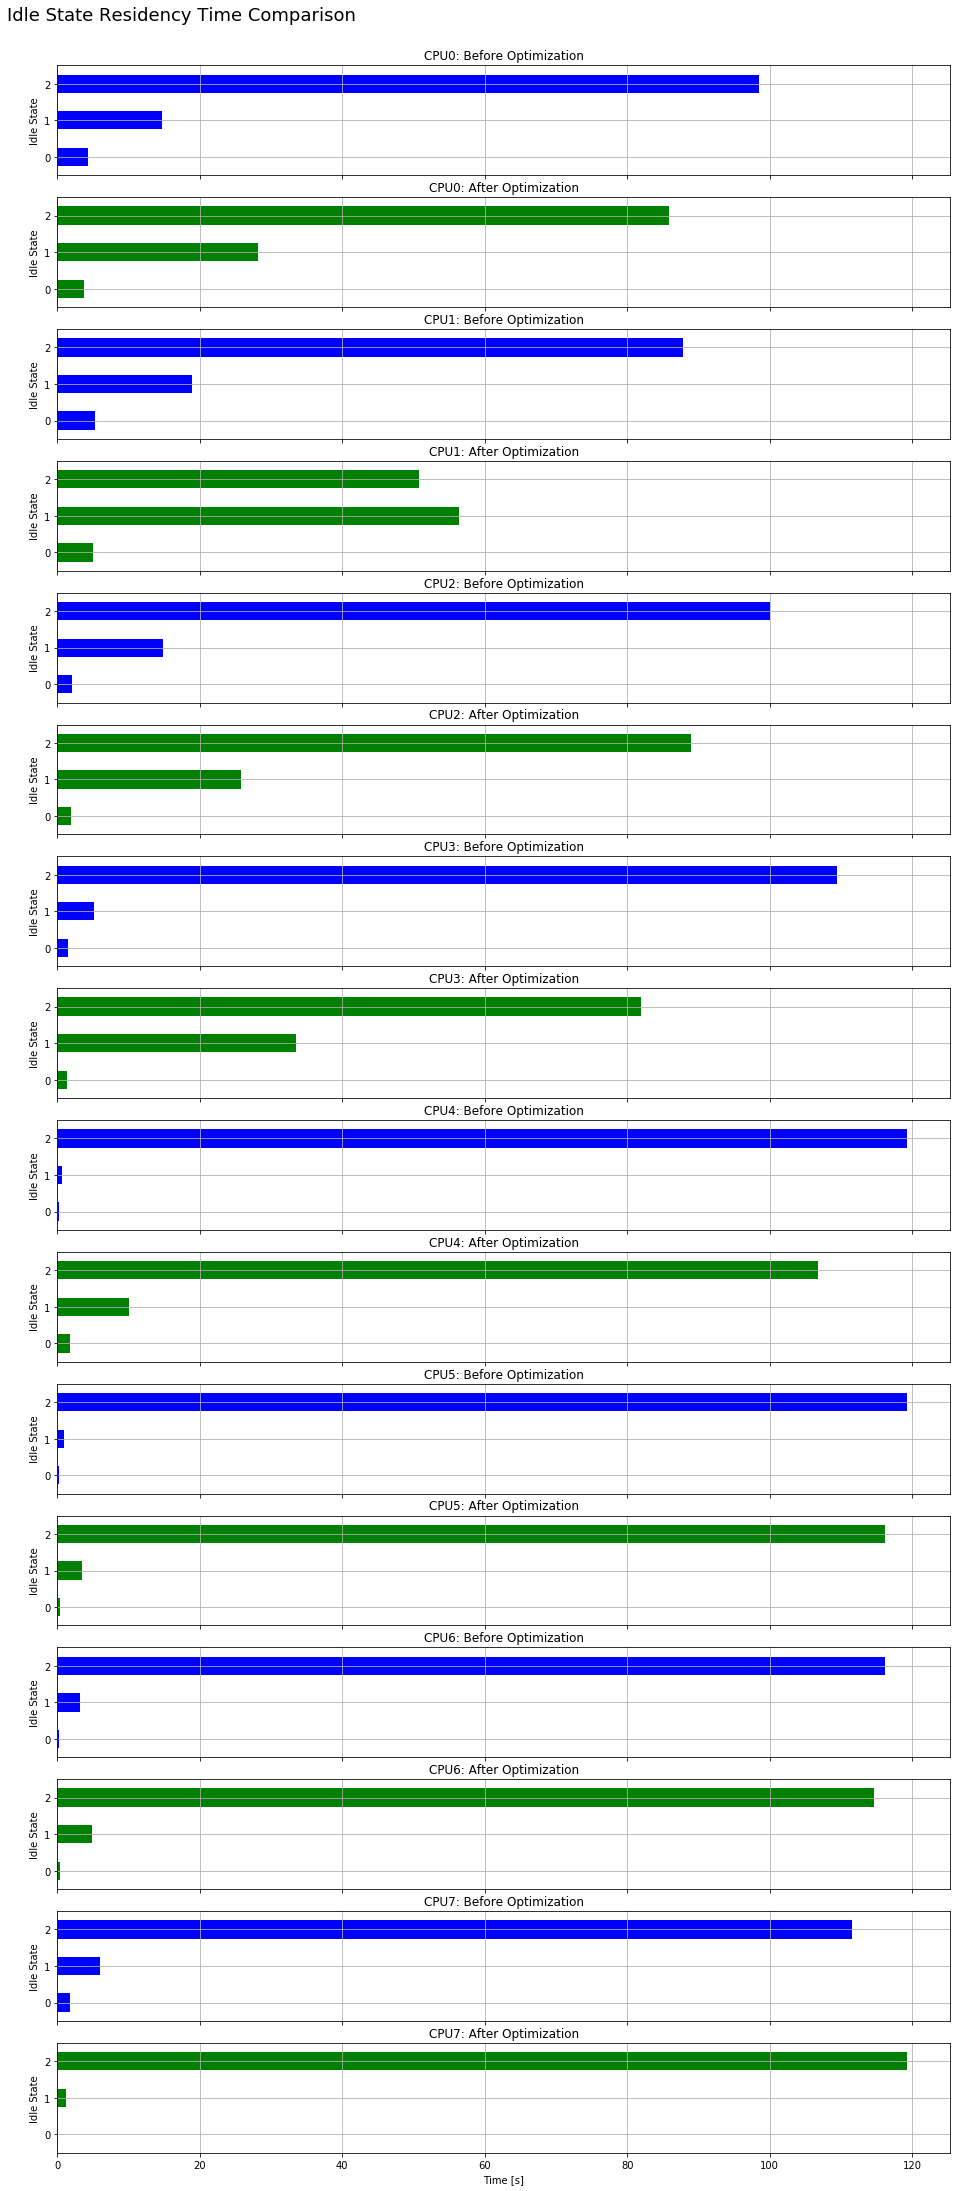

In [194]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [195]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),4.381925,14.692717,98.469772
1,CPU0(opt),3.804027,28.130015,85.824705
2,CPU0(delta),-0.577898,13.437298,-12.645067
3,CPU1(orig),5.353651,18.887523,87.833952
4,CPU1(opt),5.089956,56.404224,50.742913
5,CPU1(delta),-0.263695,37.516701,-37.091039
6,CPU2(orig),2.020732,14.866773,99.981277
7,CPU2(opt),1.939414,25.831853,88.890596
8,CPU2(delta),-0.081318,10.965080,-11.090681
9,CPU3(orig),1.565349,5.230162,109.443902


In [196]:
idle_est_prev_df = dfCPUIdleStateEstimationStatisticsHikey960(prev_ia, [ 1, 1500, 5000, 10000000000 ])
idle_est_prev_df

,good_est,over_est,under_est
CPU0-c0,6679,24,608
CPU0-c1,1618,644,862
CPU0-c2,6177,1196,0
CPU1-c0,3918,4,649
CPU1-c1,1542,917,1472
CPU1-c2,6775,1554,0
CPU2-c0,1727,1,287
CPU2-c1,872,615,1188
CPU2-c2,8299,1350,0
CPU3-c0,667,0,113


In [197]:
idle_est_post_df = dfCPUIdleStateEstimationStatisticsHikey960(post_ia, [ 1, 1500, 5000, 10000000000 ])
idle_est_post_df

,good_est,over_est,under_est
CPU0-c0,7033,21,528
CPU0-c1,3374,1550,1629
CPU0-c2,5159,4414,0
CPU1-c0,6291,6,986
CPU1-c1,6370,2084,4732
CPU1-c2,1627,6727,0
CPU2-c0,2444,1,392
CPU2-c1,2845,702,2013
CPU2-c2,2964,4814,0
CPU3-c0,1530,1,295


In [198]:
idle_est_df = idle_est_post_df - idle_est_prev_df
idle_est_df

,good_est,over_est,under_est
CPU0-c0,354,-3,-80
CPU0-c1,1756,906,767
CPU0-c2,-1018,3218,0
CPU1-c0,2373,2,337
CPU1-c1,4828,1167,3260
CPU1-c2,-5148,5173,0
CPU2-c0,717,0,105
CPU2-c1,1973,87,825
CPU2-c2,-5335,3464,0
CPU3-c0,863,1,182


# Android 4.14: exoplayer video case (state2 residency: 5000)

In [199]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent/prev_opt/video/'
trace_file = os.path.join(res_dir, "trace.dat")

In [200]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

2018-05-29 18:47:54,412 WARNING : Trace        : Failed to load tasks names from trace events
2018-05-29 18:47:59,268 INFO    : Trace        : Platform clusters verified to be Frequency coherent


In [201]:
prev_ia = trace.analysis.idle

In [202]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent/post_opt/video/'
trace_file = os.path.join(res_dir, "trace.dat")

In [203]:
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

2018-05-29 18:47:59,937 WARNING : Trace        : Failed to load tasks names from trace events
2018-05-29 18:48:05,108 INFO    : Trace        : Platform clusters verified to be Frequency coherent


In [204]:
post_ia = trace.analysis.idle

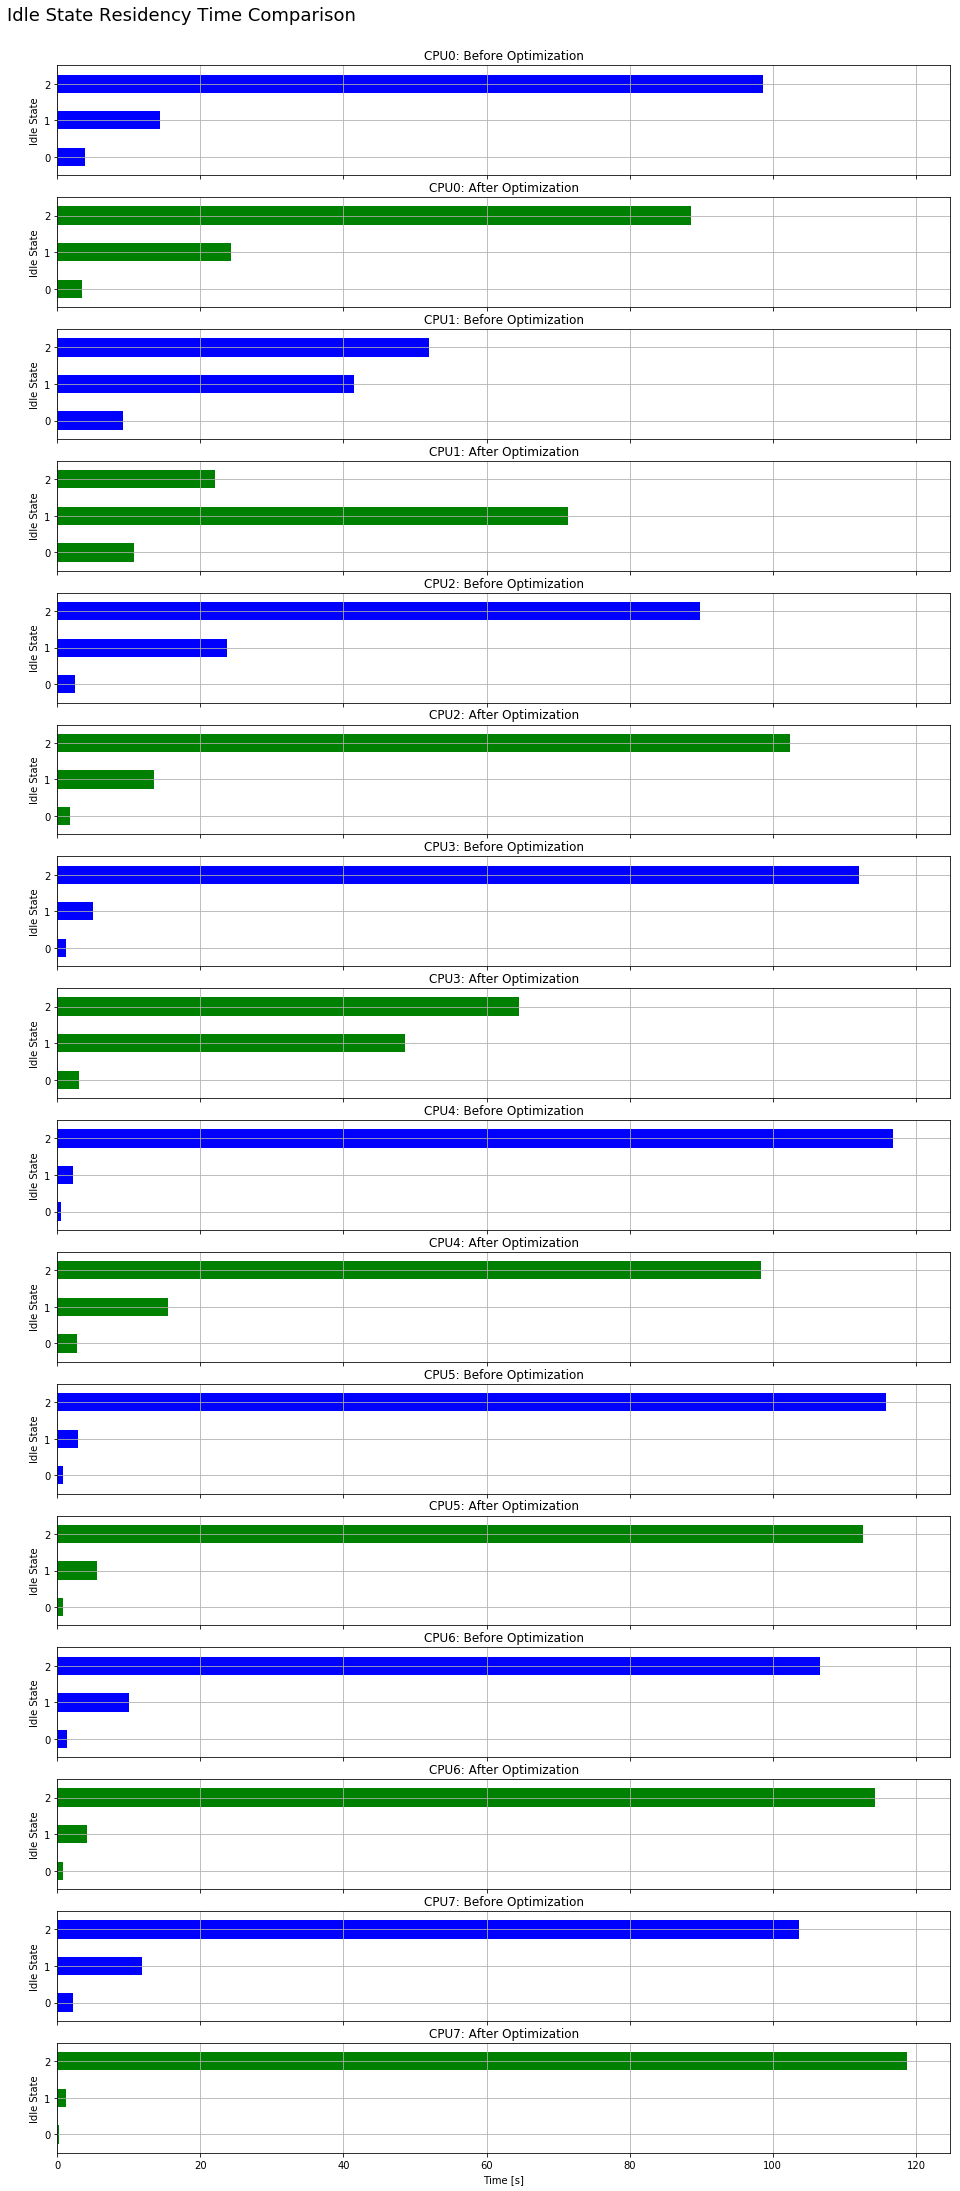

In [205]:
plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

In [206]:
df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

,index,state0,state1,state2
0,CPU0(orig),3.887309,14.377274,98.623188
1,CPU0(opt),3.418738,24.319895,88.619882
2,CPU0(delta),-0.468571,9.942621,-10.003306
3,CPU1(orig),9.154987,41.435564,51.945615
4,CPU1(opt),10.768111,71.387786,22.043066
5,CPU1(delta),1.613124,29.952222,-29.902549
6,CPU2(orig),2.445935,23.690017,89.777164
7,CPU2(opt),1.811394,13.543900,102.436488
8,CPU2(delta),-0.634541,-10.146117,12.659324
9,CPU3(orig),1.203118,5.041286,112.046261


In [207]:
idle_est_prev_df = dfCPUIdleStateEstimationStatisticsHikey960(prev_ia, [ 1, 1500, 5000, 10000000000 ])
idle_est_prev_df

,good_est,over_est,under_est
CPU0-c0,6268,37,542
CPU0-c1,1218,688,943
CPU0-c2,6386,1989,0
CPU1-c0,9353,4,1622
CPU1-c1,3759,2927,3762
CPU1-c2,5332,2201,0
CPU2-c0,2464,0,370
CPU2-c1,1289,647,2030
CPU2-c2,7754,1948,0
CPU3-c0,720,0,113


In [208]:
idle_est_post_df = dfCPUIdleStateEstimationStatisticsHikey960(post_ia, [ 1, 1500, 5000, 10000000000 ])
idle_est_post_df

,good_est,over_est,under_est
CPU0-c0,7118,66,471
CPU0-c1,2824,1326,1361
CPU0-c2,5341,4925,0
CPU1-c0,14273,16,1902
CPU1-c1,10626,4510,4989
CPU1-c2,676,7260,0
CPU2-c0,3296,6,241
CPU2-c1,1779,818,770
CPU2-c2,2250,5058,0
CPU3-c0,3379,3,501


In [209]:
idle_est_df = idle_est_post_df - idle_est_prev_df
idle_est_df

,good_est,over_est,under_est
CPU0-c0,850,29,-71
CPU0-c1,1606,638,418
CPU0-c2,-1045,2936,0
CPU1-c0,4920,12,280
CPU1-c1,6867,1583,1227
CPU1-c2,-4656,5059,0
CPU2-c0,832,6,-129
CPU2-c1,490,171,-1260
CPU2-c2,-5504,3110,0
CPU3-c0,2659,3,388


# Android 4.14: exoplayer audio case (state2 latency: 3500)

2018-05-29 18:51:02,458 WARNING : Trace        : Failed to load tasks names from trace events
2018-05-29 18:51:07,823 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2018-05-29 18:51:08,872 WARNING : Trace        : Failed to load tasks names from trace events
2018-05-29 18:51:13,513 INFO    : Trace        : Platform clusters verified to be Frequency coherent


,index,state0,state1,state2
0,CPU0(orig),5.763038,26.633476,83.968919
1,CPU0(opt),3.691568,5.898610,107.505284
2,CPU0(delta),-2.071470,-20.734866,23.536365
3,CPU1(orig),6.262182,9.648439,98.625606
4,CPU1(opt),3.986327,8.145905,99.853801
5,CPU1(delta),-2.275855,-1.502534,1.228195
6,CPU2(orig),4.190261,7.194811,104.539911
7,CPU2(opt),1.345894,3.554762,109.612445
8,CPU2(delta),-2.844367,-3.640049,5.072534
9,CPU3(orig),1.814257,1.999293,112.596101


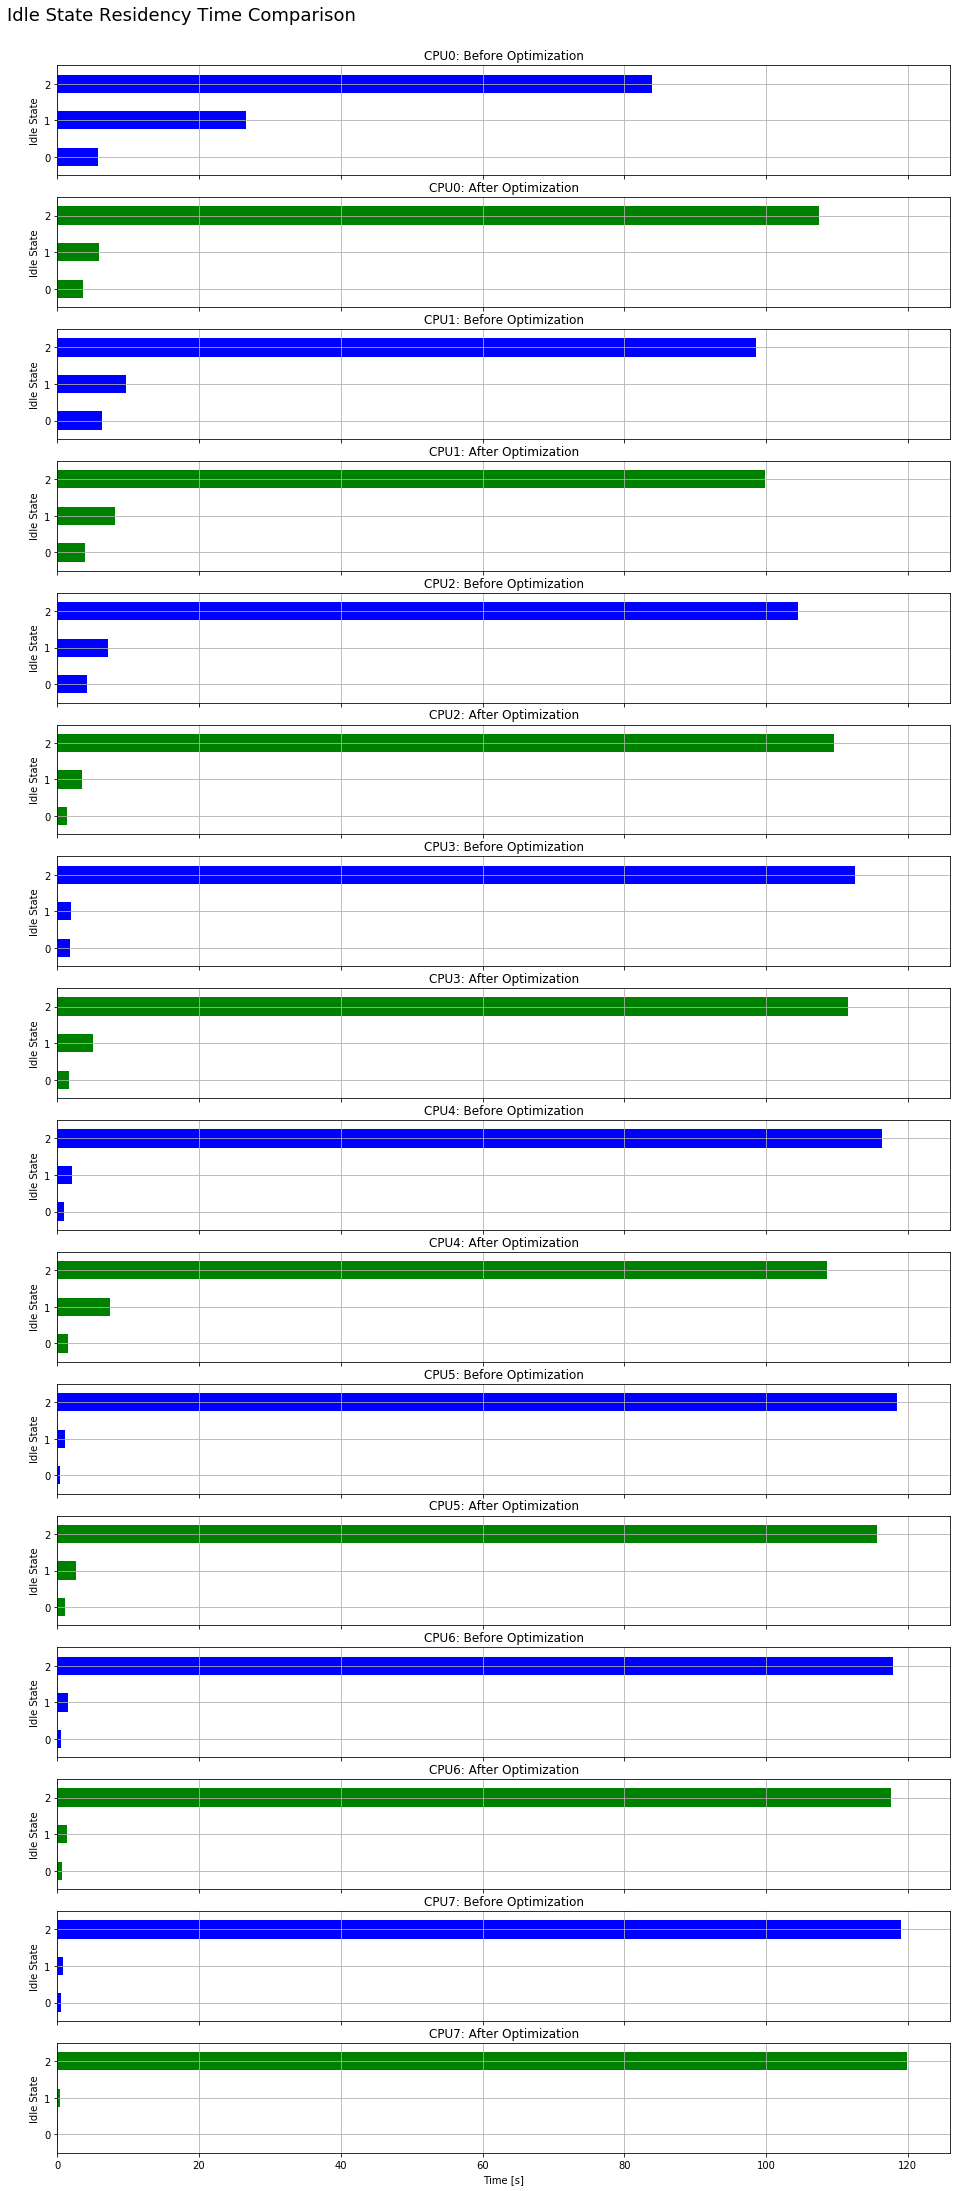

In [210]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/prev_opt/audio/'
trace_file = os.path.join(res_dir, "trace.dat")

trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

prev_ia = trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/post_opt/audio/'
trace_file = os.path.join(res_dir, "trace.dat")

trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

post_ia = trace.analysis.idle

plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

In [211]:
idle_est_prev_df = dfCPUIdleStateEstimationStatisticsHikey960(prev_ia, [ 1, 1500, 3500, 10000000000 ])
idle_est_prev_df

,good_est,over_est,under_est
CPU0-c0,7126,13,1005
CPU0-c1,1132,1150,3169
CPU0-c2,9131,3950,0
CPU1-c0,5596,1,880
CPU1-c1,813,734,1355
CPU1-c2,6601,2090,0
CPU2-c0,2856,0,320
CPU2-c1,270,285,640
CPU2-c2,5675,1699,0
CPU3-c0,339,0,353


In [212]:
idle_est_post_df = dfCPUIdleStateEstimationStatisticsHikey960(post_ia, [ 1, 1500, 3500, 10000000000 ])
idle_est_post_df

,good_est,over_est,under_est
CPU0-c0,6679,17,472
CPU0-c1,1123,495,663
CPU0-c2,8996,5439,0
CPU1-c0,5019,5,743
CPU1-c1,1235,712,1112
CPU1-c2,9357,7444,0
CPU2-c0,1466,1,256
CPU2-c1,518,218,509
CPU2-c2,8748,5855,0
CPU3-c0,2624,3,282


In [213]:
idle_est_df = idle_est_post_df - idle_est_prev_df
idle_est_df

,good_est,over_est,under_est
CPU0-c0,-447,4,-533
CPU0-c1,-9,-655,-2506
CPU0-c2,-135,1489,0
CPU1-c0,-577,4,-137
CPU1-c1,422,-22,-243
CPU1-c2,2756,5354,0
CPU2-c0,-1390,1,-64
CPU2-c1,248,-67,-131
CPU2-c2,3073,4156,0
CPU3-c0,2285,3,-71


# Android 4.14: exoplayer video case (state2 latency: 3500)

2018-05-29 18:53:35,632 WARNING : Trace        : Failed to load tasks names from trace events
2018-05-29 18:53:40,456 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2018-05-29 18:53:41,844 WARNING : Trace        : Failed to load tasks names from trace events
2018-05-29 18:53:47,240 INFO    : Trace        : Platform clusters verified to be Frequency coherent


,index,state0,state1,state2
0,CPU0(orig),4.532772,29.360880,81.342410
1,CPU0(opt),2.798692,4.959856,108.083540
2,CPU0(delta),-1.734080,-24.401024,26.741130
3,CPU1(orig),8.981622,31.750331,65.266204
4,CPU1(opt),7.487549,16.442921,77.196311
5,CPU1(delta),-1.494073,-15.307410,11.930107
6,CPU2(orig),4.142876,10.515758,101.452823
7,CPU2(opt),2.449707,5.291669,108.543294
8,CPU2(delta),-1.693169,-5.224089,7.090471
9,CPU3(orig),0.895216,3.261008,113.481006


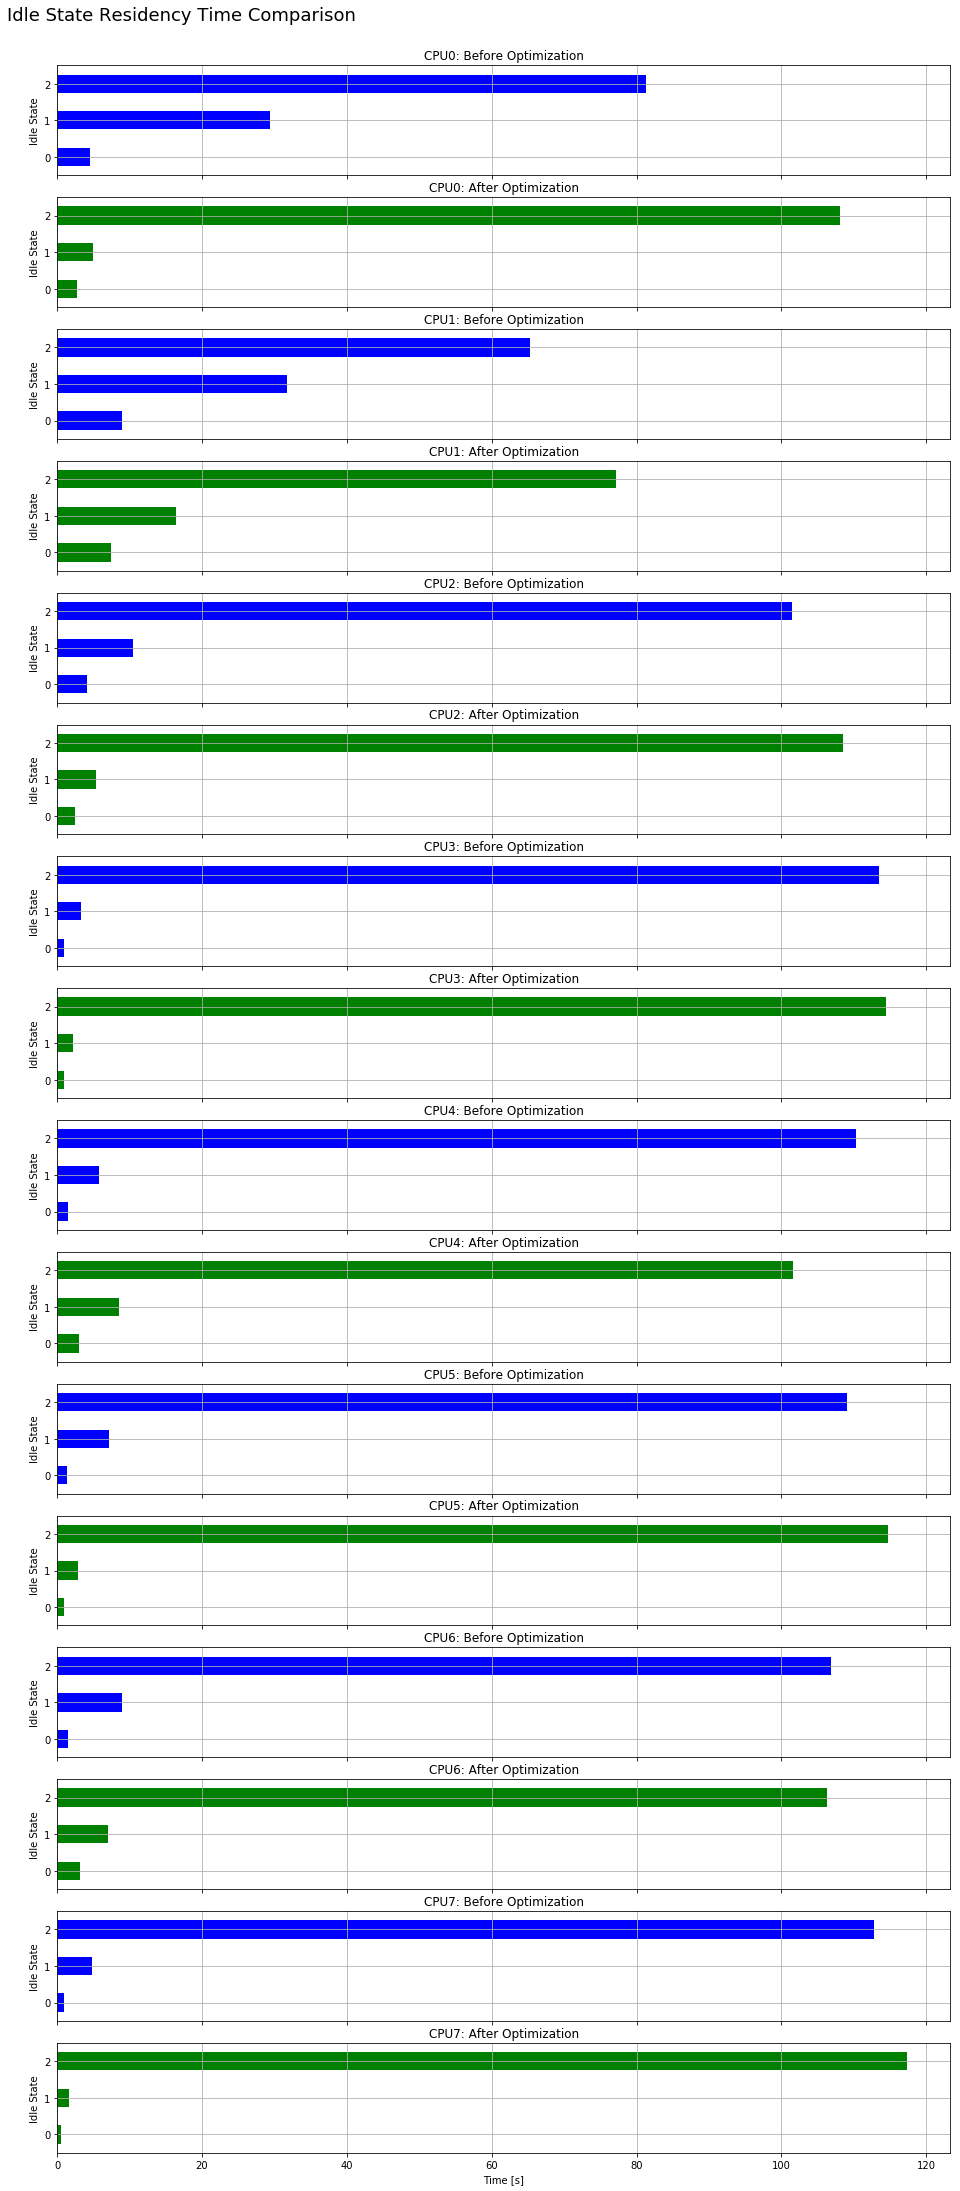

In [214]:
res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/prev_opt/video/'
trace_file = os.path.join(res_dir, "trace.dat")

trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

prev_ia = trace.analysis.idle

res_dir = '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/android-4.14-vincent-state2/post_opt/video/'
trace_file = os.path.join(res_dir, "trace.dat")

trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'], normalize_time=True)

post_ia = trace.analysis.idle

plotCPUIdleStateResidencyComparison(prev_ia, post_ia)

df = dfCPUIdleStateResidencyComparison(prev_ia, post_ia)
df

In [215]:
idle_est_prev_df = dfCPUIdleStateEstimationStatisticsHikey960(prev_ia, [ 1, 1500, 3500, 10000000000 ])
idle_est_prev_df

,good_est,over_est,under_est
CPU0-c0,5442,40,802
CPU0-c1,1195,1343,3388
CPU0-c2,8943,4723,0
CPU1-c0,8964,9,1375
CPU1-c1,1591,2963,3586
CPU1-c2,6918,4817,0
CPU2-c0,2565,1,352
CPU2-c1,431,497,1225
CPU2-c2,5784,2132,0
CPU3-c0,940,2,166


In [216]:
idle_est_post_df = dfCPUIdleStateEstimationStatisticsHikey960(post_ia, [ 1, 1500, 3500, 10000000000 ])
idle_est_post_df

,good_est,over_est,under_est
CPU0-c0,5565,53,379
CPU0-c1,936,614,555
CPU0-c2,9008,5988,0
CPU1-c0,10391,7,1232
CPU1-c1,2720,1543,2056
CPU1-c2,9655,12040,0
CPU2-c0,4603,3,334
CPU2-c1,402,297,988
CPU2-c2,4940,3127,0
CPU3-c0,1245,0,147


In [217]:
idle_est_df = idle_est_post_df - idle_est_prev_df
idle_est_df

,good_est,over_est,under_est
CPU0-c0,123,13,-423
CPU0-c1,-259,-729,-2833
CPU0-c2,65,1265,0
CPU1-c0,1427,-2,-143
CPU1-c1,1129,-1420,-1530
CPU1-c2,2737,7223,0
CPU2-c0,2038,2,-18
CPU2-c1,-29,-200,-237
CPU2-c2,-844,995,0
CPU3-c0,305,-2,-19


# Energy comparison

In [55]:
def nrg_calculation(prev_csv, post_csv):
    prev_df = pd.read_csv(prev_csv, names=['id','workload','iteration','metric','value','unit'])
    post_df = pd.read_csv(post_csv, names=['id','workload','iteration','metric','value','unit'])
    
    prev_df = prev_df.drop(prev_df.index[0])
    post_df = post_df.drop(post_df.index[0])

    prev_df.value = prev_df.value.astype(float).fillna(0.0)
    post_df.value = post_df.value.astype(float).fillna(0.0)
    
    #print prev_df
    #print post_df
    
    diff_df = (post_df['value'] - prev_df['value']) / (prev_df['value']) * 100
    print 'audio (SYS)  power: %.2f' % diff_df[5] + '%'
    print 'audio (VDD)  power: %.2f' % diff_df[6] + '%'
    print 'audio (DCIN) power: %.2f' % diff_df[7] + '%'
    print 'video (SYS)  power: %.2f' % diff_df[12] + '%'
    print 'video (VDD)  power: %.2f' % diff_df[13] + '%'
    print 'video (DCIN) power: %.2f' % diff_df[14] + '%'    


In [56]:
nrg_calculation('/home/leoy/Work2/Develop/test/cpuidle_loop_rework/power_data/prev_opt/results.csv',
                '/home/leoy/Work2/Develop/test/cpuidle_loop_rework/power_data/post_opt/results.csv')

audio (SYS)  power: -9.19%
audio (VDD)  power: -29.18%
audio (DCIN) power: -26.02%
video (SYS)  power: -2.69%
video (VDD)  power: -0.77%
video (DCIN) power: 1.85%
